# 텍스트 분류

<img alt="Tesla Tweet" width="500" caption="Analyzing Twitter content can yield useful feedback from customers (courtesy of Aditya Veluri)" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter02_tweet.png?raw=1" id="tesla-tweet"/>

<img alt="Hugging Face Pipeline" caption="A typical pipeline for training transformer models with the image:images/logo.png[hf,13,13] Datasets, image:images/logo.png[hf,13,13] Tokenizers, and image:images/logo.png[hf,13,13] Transformers libraries" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter02_hf-libraries.png?raw=1" id="hf-libraries"/>

## 데이터셋

### 허깅 페이스 데이터셋 처음 사용하기

In [1]:
from datasets import list_datasets

all_datasets = list_datasets()
print(f"현재 허브에는 {len(all_datasets)}개의 데이터셋이 있습니다.")
print(f"처음 10개 데이터셋: {all_datasets[:10]}")

C:\Users\XR\AppData\Local\Temp\ipykernel_10652\3666915235.py:3: FutureWarning: list_datasets is deprecated and will be removed in the next major version of datasets. Use 'huggingface_hub.list_datasets' instead.
  all_datasets = list_datasets()


현재 허브에는 53571개의 데이터셋이 있습니다.
처음 10개 데이터셋: ['acronym_identification', 'ade_corpus_v2', 'adversarial_qa', 'aeslc', 'afrikaans_ner_corpus', 'ag_news', 'ai2_arc', 'air_dialogue', 'ajgt_twitter_ar', 'allegro_reviews']


### 각 데이터셋은 고유한 이름이 있습니다. `load_dataset()` 함수로 `emotion` 데이터셋을 로드.

In [2]:
from datasets import load_dataset

# emotion 데이터셋이 다운로드되지 않으면 SetFit/emotion을 사용합니다.
emotions = load_dataset("emotion")

In [3]:
emotions = load_dataset("emotion")
emotions['train'].features['label']

ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)

In [4]:
# SetFit/emotion 데이터셋의 경우 수동으로 ClassLabel 객체를 만들어 label에 할당합니다.
from datasets import ClassLabel

emotions['train'].features['label'] = ClassLabel(
    num_classes=6, 
    names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'])

In [5]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [6]:
train_ds = emotions["train"]
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [7]:
len(train_ds)

16000

In [8]:
train_ds[0]

{'text': 'i didnt feel humiliated', 'label': 0}

In [9]:
train_ds.column_names

['text', 'label']

In [10]:
print(train_ds.features)

{'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}


In [11]:
print(train_ds[:5])

{'text': ['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'im grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'i am feeling grouchy'], 'label': [0, 0, 3, 2, 3]}


In [12]:
print(train_ds["text"][:5])

['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'im grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'i am feeling grouchy']


### 데이터셋에서 데이터프레임으로

In [13]:
import pandas as pd

emotions.set_format(type="pandas")
df = emotions["train"][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [14]:
emotions["train"].features['label'].__class__

datasets.features.features.ClassLabel

In [15]:
def label_int2str(row):
    return emotions["train"].features["label"].int2str(row)

df["label_name"] = df["label"].apply(label_int2str)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


### 클래스 분포 살펴 보기

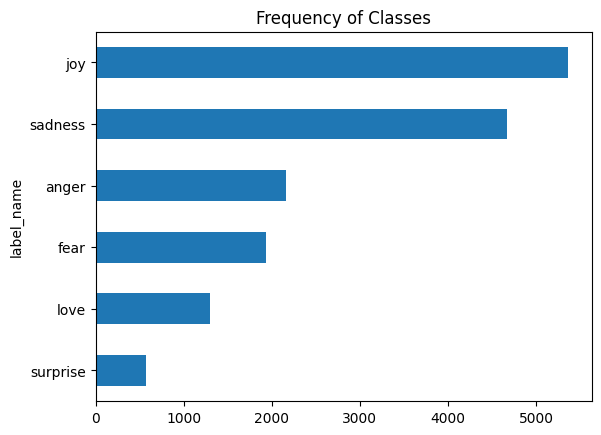

In [16]:
import matplotlib.pyplot as plt

df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

### 트윗 길이 확인

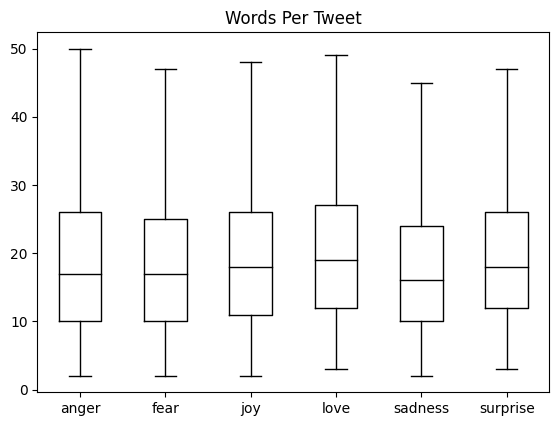

In [17]:
df["Words Per Tweet"] = df["text"].str.split().apply(len)
df.boxplot("Words Per Tweet", by="label_name", grid=False, showfliers=False,
           color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()

In [18]:
emotions.reset_format()

## 텍스트에서 토큰으로

### 문자 토큰

In [19]:
text = "Tokenizing text is a core task of NLP."
tokenized_text = list(text)
print(tokenized_text)

['T', 'o', 'k', 'e', 'n', 'i', 'z', 'i', 'n', 'g', ' ', 't', 'e', 'x', 't', ' ', 'i', 's', ' ', 'a', ' ', 'c', 'o', 'r', 'e', ' ', 't', 'a', 's', 'k', ' ', 'o', 'f', ' ', 'N', 'L', 'P', '.']


In [20]:
token2idx = {ch: idx for idx, ch in enumerate(sorted(set(tokenized_text)))}
print(token2idx)

{' ': 0, '.': 1, 'L': 2, 'N': 3, 'P': 4, 'T': 5, 'a': 6, 'c': 7, 'e': 8, 'f': 9, 'g': 10, 'i': 11, 'k': 12, 'n': 13, 'o': 14, 'r': 15, 's': 16, 't': 17, 'x': 18, 'z': 19}


In [21]:
input_ids = [token2idx[token] for token in tokenized_text]
print(input_ids)

[5, 14, 12, 8, 13, 11, 19, 11, 13, 10, 0, 17, 8, 18, 17, 0, 11, 16, 0, 6, 0, 7, 14, 15, 8, 0, 17, 6, 16, 12, 0, 14, 9, 0, 3, 2, 4, 1]


In [22]:
categorical_df = pd.DataFrame(
    {"Name": ["Bumblebee", "Optimus Prime", "Megatron"], "Label ID": [0,1,2]})
categorical_df

,Name,Label ID
0,Bumblebee,0
1,Optimus Prime,1
2,Megatron,2


In [23]:
pd.get_dummies(categorical_df["Name"])

,Bumblebee,Megatron,Optimus Prime
0,True,False,False
1,False,False,True
2,False,True,False


In [24]:
import torch
import torch.nn.functional as F

input_ids = torch.tensor(input_ids)
one_hot_encodings = F.one_hot(input_ids, num_classes=len(token2idx))
one_hot_encodings.shape

torch.Size([38, 20])

In [25]:
print(f"토큰: {tokenized_text[0]}")
print(f"텐서 인덱스: {input_ids[0]}")
print(f"원-핫 인코딩: {one_hot_encodings[0]}")

토큰: T
텐서 인덱스: 5
원-핫 인코딩: tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


In [26]:
F.one_hot(torch.tensor([0,2]), num_classes=11).shape

torch.Size([2, 11])

### 단어 토큰화

In [27]:
tokenized_text = text.split()
print(tokenized_text)

['Tokenizing', 'text', 'is', 'a', 'core', 'task', 'of', 'NLP.']


### 부분단어 토큰화

In [28]:
from transformers import AutoTokenizer

model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [29]:
encoded_text = tokenizer(text)
print(encoded_text)

{'input_ids': [101, 19204, 6026, 3793, 2003, 1037, 4563, 4708, 1997, 17953, 2361, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [30]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)

['[CLS]', 'token', '##izing', 'text', 'is', 'a', 'core', 'task', 'of', 'nl', '##p', '.', '[SEP]']


In [31]:
print(tokenizer.convert_tokens_to_string(tokens))

[CLS] tokenizing text is a core task of nlp. [SEP]


In [32]:
tokenizer.vocab_size

30522

In [33]:
tokenizer.model_max_length

512

In [34]:
tokenizer.model_input_names

['input_ids', 'attention_mask']

### 전체 데이터셋 토큰화하기

In [35]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

In [36]:
print(tokenize(emotions["train"][:2]))

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


In [37]:
tokens2ids = list(zip(tokenizer.all_special_tokens, tokenizer.all_special_ids))
data = sorted(tokens2ids, key=lambda x : x[-1])
df = pd.DataFrame(data, columns=["Special Token", "Special Token ID"])
df.T

,0,1,2,3,4
Special Token,[PAD],[UNK],[CLS],[SEP],[MASK]
Special Token ID,0,100,101,102,103


<img alt="attention-mask" caption="For each batch, the input sequences are padded to the maximum sequence length in the batch; the attention mask is used in the model to ignore the padded areas of the input tensors" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter02_attention-mask.png?raw=1" id="attention-mask"/> 

In [38]:
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

In [39]:
print(emotions_encoded["train"].column_names)

['text', 'label', 'input_ids', 'attention_mask']


## 텍스트 분류 모델 훈련하기

<img alt="encoder-classifier" caption="The architecture used for sequence classification with an encoder-based transformer; it consists of the model's pretrained body (blue) combined with a custom classification head (orange)" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter02_encoder-classifier.png?raw=1" id="encoder-classifier"/>

### 트랜스포머를 특성 추출기로 사용하기

<img alt="encoder-features" caption="In the feature-based approach, the DistilBERT model is frozen and just provides features for a classifier" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter02_encoder-feature-based.png?raw=1" id="encoder-features"/>

#### 사전 훈련된 모델 사용하기

In [40]:
from transformers import AutoModel

model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


#### 마지막 은닉 상태 추출하기

In [41]:
text = "this is a test"
inputs = tokenizer(text, return_tensors="pt")
print(f"입력 텐서 크기: {inputs['input_ids'].size()}")

입력 텐서 크기: torch.Size([1, 6])


In [42]:
inputs = {k:v.to(device) for k,v in inputs.items()}
with torch.no_grad():
    outputs = model(**inputs)
print(outputs)

BaseModelOutput(last_hidden_state=tensor([[[-0.1565, -0.1862,  0.0528,  ..., -0.1188,  0.0662,  0.5470],
         [-0.3575, -0.6484, -0.0618,  ..., -0.3040,  0.3508,  0.5221],
         [-0.2772, -0.4459,  0.1818,  ..., -0.0948, -0.0076,  0.9958],
         [-0.2841, -0.3917,  0.3753,  ..., -0.2151, -0.1173,  1.0526],
         [ 0.2661, -0.5094, -0.3180,  ..., -0.4203,  0.0144, -0.2149],
         [ 0.9441,  0.0112, -0.4714,  ...,  0.1439, -0.7288, -0.1619]]],
       device='cuda:0'), hidden_states=None, attentions=None)


In [43]:
outputs.last_hidden_state.size()

torch.Size([1, 6, 768])

In [44]:
outputs.last_hidden_state[:,0].size()

torch.Size([1, 768])

In [45]:
def extract_hidden_states(batch):
    # 모델 입력을 GPU로 옮깁니다.
    inputs = {k:v.to(device) for k,v in batch.items() 
              if k in tokenizer.model_input_names}
    # 마지막 은닉 상태를 추출합니다.
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    # [CLS] 토큰에 대한 벡터를 반환합니다.
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

In [46]:
emotions_encoded.set_format("torch", 
                            columns=["input_ids", "attention_mask", "label"])

In [47]:
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)

In [48]:
emotions_hidden["train"].column_names

['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']

#### 특성 행렬 만들기

In [49]:
import numpy as np

X_train = np.array(emotions_hidden["train"]["hidden_state"])
X_valid = np.array(emotions_hidden["validation"]["hidden_state"])
y_train = np.array(emotions_hidden["train"]["label"])
y_valid = np.array(emotions_hidden["validation"]["label"])
X_train.shape, X_valid.shape

((16000, 768), (2000, 768))

#### 훈련 세트 시각화하기

In [50]:
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler

# 특성 스케일을 [0,1] 범위로 조정합니다.
X_scaled = MinMaxScaler().fit_transform(X_train)
# UMAP 객체를 생성하고 훈련시킵니다.
mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)
# 2D 임베딩의 데이터프레임을 만듭니다.
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["label"] = y_train
df_emb.head()

C:\Users\XR\AppData\Local\Programs\Python\Python311\Lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
C:\Users\XR\AppData\Local\Programs\Python\Python311\Lib\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
C:\Users\XR\AppData\Local\Programs\Python\Python311\Lib\si

,X,Y,label
0,4.162616,6.264065,0
1,-3.190705,5.237082,0
2,4.989628,2.900899,3
3,-2.525811,3.390700,2
4,-3.452358,3.394133,3


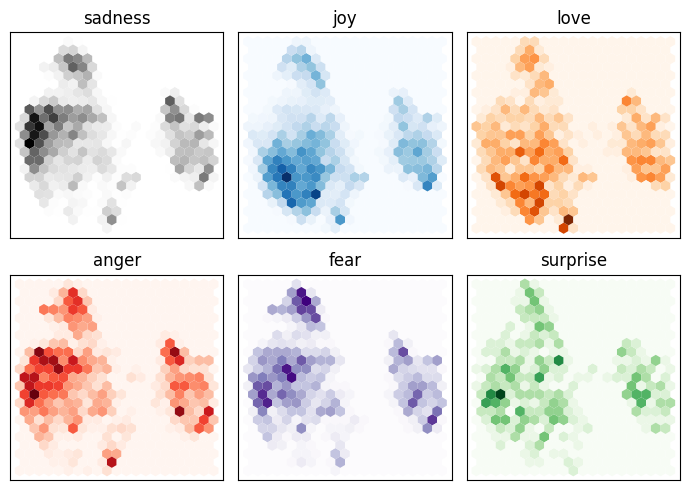

In [51]:
fig, axes = plt.subplots(2, 3, figsize=(7,5))
axes = axes.flatten()
cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens"]
labels = emotions["train"].features["label"].names

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f"label == {i}")
    axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap,
                   gridsize=20, linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([]), axes[i].set_yticks([])

plt.tight_layout()
plt.show()

#### 간단한 분류 모델 훈련하기

In [52]:
# 수렴을 보장하기 위해 `max_iter`를 증가시킵니다.
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)

LogisticRegression(max_iter=3000)

In [53]:
lr_clf.score(X_valid, y_valid)

0.6335

In [54]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_valid, y_valid)

0.352

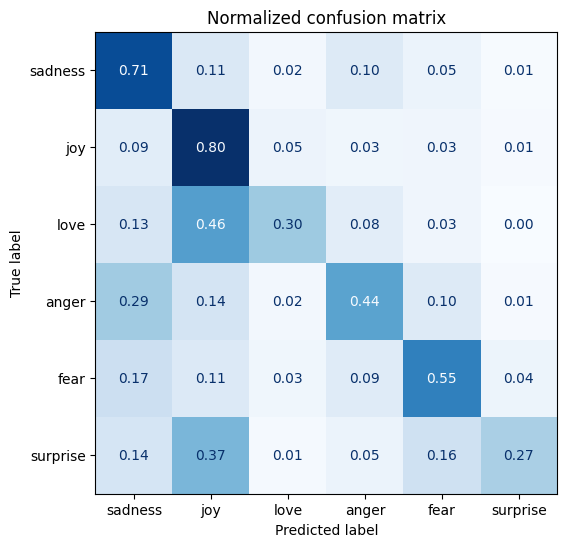

In [55]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()
    
y_preds = lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, labels)

### 트랜스포머 미세 튜닝하기

<img alt="encoder-tuning" caption="When using the fine-tuning approach the whole DistilBERT model is trained along with the classification head" src="https://github.com/rickiepark/nlp-with-transformers/blob/main/images/chapter02_encoder-fine-tuning.png?raw=1" id="encoder-tuning"/>

#### 사전 훈련된 모델 로드하기

In [56]:
from transformers import AutoModelForSequenceClassification

num_labels = 6
model = (AutoModelForSequenceClassification
         .from_pretrained(model_ckpt, num_labels=num_labels)
         .to(device))

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'classifier.weight', 'pre_classifier.

#### 성공 지표 정의하기

In [57]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

#### 모델 훈련하기

In [58]:
from huggingface_hub import notebook_login

notebook_login()

In [59]:
from transformers import Trainer, TrainingArguments

batch_size = 64
logging_steps = len(emotions_encoded["train"]) // batch_size
model_name = f"{model_ckpt}-finetuned-emotion"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=True, 
                                  save_strategy="epoch",
                                  load_best_model_at_end=True,
                                  log_level="error")

In [60]:
from transformers import Trainer

trainer = Trainer(model=model, args=training_args, 
                  compute_metrics=compute_metrics,
                  train_dataset=emotions_encoded["train"],
                  eval_dataset=emotions_encoded["validation"],
                  tokenizer=tokenizer)
trainer.train();

Cloning https://huggingface.co/Dan22dongwon/distilbert-base-uncased-finetuned-emotion into local empty directory.


Download file pytorch_model.bin:   0%|          | 18.4k/255M [00:00<?, ?B/s]

Download file training_args.bin: 100%|##########| 3.93k/3.93k [00:00<?, ?B/s]

Clean file training_args.bin:  25%|##5       | 1.00k/3.93k [00:00<?, ?B/s]

Clean file pytorch_model.bin:   0%|          | 1.00k/255M [00:00<?, ?B/s]

C:\Users\XR\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.806100,0.302601,0.909000,0.906458
2,0.238800,0.216600,0.924500,0.924590


In [61]:
preds_output = trainer.predict(emotions_encoded["validation"])

In [62]:
preds_output.metrics

{'test_loss': 0.2166004776954651,
 'test_accuracy': 0.9245,
 'test_f1': 0.924589774710226,
 'test_runtime': 0.9622,
 'test_samples_per_second': 2078.549,
 'test_steps_per_second': 33.257}

In [63]:
y_preds = np.argmax(preds_output.predictions, axis=1)

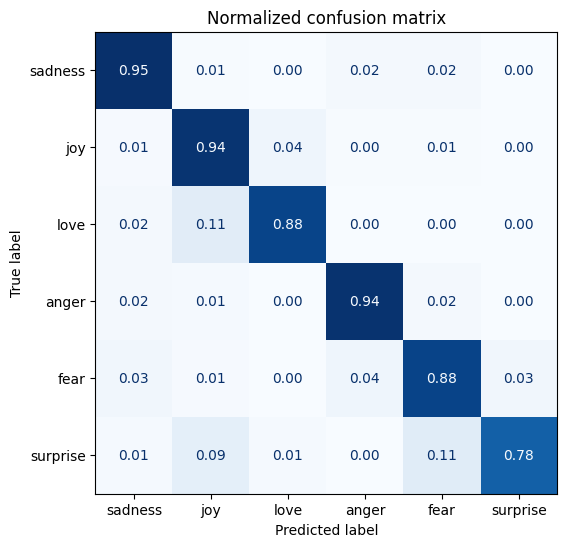

In [64]:
plot_confusion_matrix(y_preds, y_valid, labels)

#### 오류 분석

In [65]:
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
    # 모든 입력 텐서를 모델과 같은 장치로 이동합니다.
    inputs = {k:v.to(device) for k,v in batch.items() 
              if k in tokenizer.model_input_names}

    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, batch["label"].to(device), 
                             reduction="none")

    # 다른 데이터셋 열과 호환되도록 출력을 CPU로 옮깁니다.
    return {"loss": loss.cpu().numpy(), 
            "predicted_label": pred_label.cpu().numpy()}

In [66]:
# 데이터셋을 다시 파이토치 텐서로 변환합니다.
emotions_encoded.set_format("torch", 
                            columns=["input_ids", "attention_mask", "label"])
# 손실 값을 계산합니다.
emotions_encoded["validation"] = emotions_encoded["validation"].map(
    forward_pass_with_label, batched=True, batch_size=16)

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [67]:
emotions_encoded.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]
df_test = emotions_encoded["validation"][:][cols]
df_test["label"] = df_test["label"].apply(label_int2str)
df_test["predicted_label"] = (df_test["predicted_label"]
                              .apply(label_int2str))

In [68]:
df_test.sort_values("loss", ascending=False).head(10)

,text,label,predicted_label,loss
1801,i feel that he was being overshadowed by the s...,love,sadness,5.405293
1111,im lazy my characters fall into categories of ...,joy,fear,5.362088
1963,i called myself pro life and voted for perry w...,joy,sadness,5.253924
1870,i guess i feel betrayed because i admired him ...,joy,sadness,5.235865
882,i feel badly about reneging on my commitment t...,love,sadness,5.209146
1500,i guess we would naturally feel a sense of lon...,anger,sadness,5.080216
1274,i am going to several holiday parties and i ca...,joy,sadness,4.834109
318,i felt ashamed of these feelings and was scare...,fear,sadness,4.546839
765,i feel super awkward and out of place right now,joy,sadness,4.409359
1950,i as representative of everything thats wrong ...,surprise,sadness,4.388404


In [69]:
df_test.sort_values("loss", ascending=True).head(10)

,text,label,predicted_label,loss
1601,i feel so ungrateful when thinking saying thes...,sadness,sadness,0.016713
1310,i feel like an ungrateful asshole,sadness,sadness,0.016978
1531,i forgive stanley hes not so quick to forgive ...,sadness,sadness,0.017002
267,i feel like im alone in missing him and becaus...,sadness,sadness,0.017061
1656,im feeling very jaded and uncertain about love...,sadness,sadness,0.017085
21,i feel try to tell me im ungrateful tell me im...,sadness,sadness,0.017120
1041,i suppose it all goes along with feeling unwel...,sadness,sadness,0.017238
1140,i do think about certain people i feel a bit d...,sadness,sadness,0.017314
1965,i started feeling pathetic and ashamed,sadness,sadness,0.017325
133,i and feel quite ungrateful for it but i m loo...,sadness,sadness,0.017339


#### 모델 저장 및 공유

In [70]:
trainer.push_to_hub(commit_message="Training completed!")

Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


Upload file pytorch_model.bin:   0%|          | 1.00/255M [00:00<?, ?B/s]

To https://huggingface.co/Dan22dongwon/distilbert-base-uncased-finetuned-emotion
   5b0cf67..7fbc690  main -> main

To https://huggingface.co/Dan22dongwon/distilbert-base-uncased-finetuned-emotion
   7fbc690..f9d68df  main -> main



'https://huggingface.co/Dan22dongwon/distilbert-base-uncased-finetuned-emotion/commit/7fbc690c1dded4691462b4117f3b6fb160f61886'

In [132]:
from transformers import pipeline

# `haesun`를 자신의 허브 사용자 이름으로 바꾸세요.
model_id = "Dan22dongwon/distilbert-base-uncased-finetuned-emotion"
classifier = pipeline("text-classification", model=model_id)

In [133]:
custom_tweet = "I saw a movie today, it bugged me."
preds = classifier(custom_tweet, return_all_scores=True)

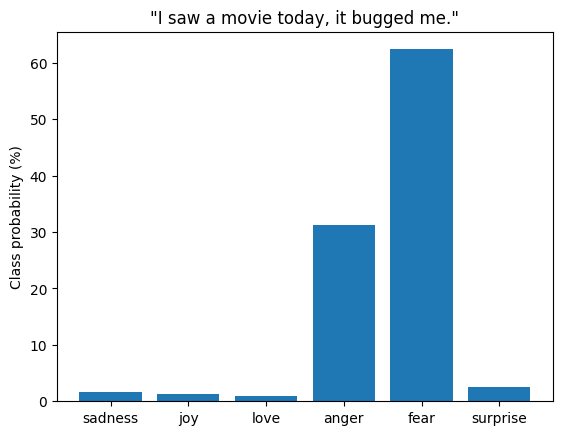

In [134]:
preds_df = pd.DataFrame(preds[0])
plt.bar(labels, 100 * preds_df["score"], color='C0')
plt.title(f'"{custom_tweet}"')
plt.ylabel("Class probability (%)")
plt.show()

## 결론